- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [2]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [5]:
period = 4096

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 915

915

In [7]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [9]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

- we can see that the rolling ensemble model much better than train/test


- now we go for the next part: the intraday medium frequency trading

    
- at this time, we do not need to close position every day
- and we cannot use parallel computing for daily pnl because one day's pnl depends on previous position
- but we can still use parallel for each contract because they are independent


- now let's first find the days of each contract

In [18]:
def get_contract(file):
    data = load(file)
    return data["contract"][data["good"]].iloc[0]

In [21]:
contract_list=dict([])
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    contract_vec = pd.Series(list(map(get_contract, file_list)))
    save(contract_vec, HEAD_PATH+"/"+product+".contract.vec.pkl")
    contract_list[product] = contract_vec

In [22]:
save(contract_list, HEAD_PATH+"/.contract.list.pkl")

In [26]:
contract_list = load(HEAD_PATH+"/.contract.list.pkl")
product_cum = dict([])
product_len = dict([])
for product in product_list:
    contract_vec = contract_list[product]
    contract_len = contract_vec.value_counts().sort_index()
    contract_cum = contract_len.cumsum()
    product_len[product] = contract_len
    product_cum[product] = contract_cum

- we know that lasso.4096 is trained using data before 2018
- however our contract is not splited in this way
- so we may need to comply to the data of this format

In [59]:
product = "rb"
train_sample_list = dict([])
test_sample_list = dict([])
for product in product_list:
    contract_cum = product_cum[product]
    split_date = all_dates[contract_cum[np.max(np.where(all_dates[contract_cum-1]<"2018"))]]
    medium_train_sample = (all_dates<split_date)
    medium_test_sample = (all_dates>=split_date)
    train_sample_list[product] = medium_train_sample
    test_sample_list[product] = medium_test_sample

In [68]:
train_std = dict([])
all_x_train = dict([])
all_y_train = dict([])
n_sample = 0
for product in product_list:
    medium_train_sample = train_sample_list[product]
    medium_test_sample = test_sample_list[product]
    medium_train_range = range(round(sum((daily_ticks[product][medium_train_sample]))))
    medium_test_range = np.arange(sum(daily_ticks[product][medium_train_sample])+1,sum(daily_ticks[product]))
    medium_train_mat = all_mat[product].iloc[medium_train_range,:]
    medium_test_mat = all_mat[product].iloc[medium_test_range,:]
    x_train = medium_train_mat.iloc[:,:n_signal]
    y_train = medium_train_mat[y_signal]
    train_std[product] = np.std(medium_train_mat)
    all_x_train[product] = x_train
    all_y_train[product] = y_train
    n_sample = n_sample+len(y_train)

In [88]:
x_train = np.zeros((n_sample, n_signal))
y_train = np.zeros(n_sample)
cur = 0
for product in product_list:
    x_train[cur:(cur+len(all_y_train[product])),] = all_x_train[product]/train_std[product][:n_signal]
    y_train[cur:(cur+len(all_y_train[product]))] = all_y_train[product]/train_std[product][y_signal]
    cur = cur+len(all_y_train[product])

In [92]:
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train, y_train)
fit_coef = model.coef_
fit_coef
# array([ 0.        , -0.        ,  0.00702577, -0.        ,  0.        ,
#         0.02721336, -0.        ,  0.        ,  0.        , -0.        ,
#        -0.        ,  0.        , -0.        , -0.        , -0.        ,
#         0.        ,  0.        , -0.        , -0.00021274, -0.01622379,
#         0.        , -0.02725756, -0.02136017, -0.        , -0.        ,
#        -0.        , -0.        , -0.        ,  0.        ,  0.00089115,
#        -0.00997168, -0.        ,  0.        ,  0.        ,  0.        ,
#        -0.        , -0.        ,  0.        ,  0.00830943, -0.        ,
#         0.        ,  0.        ,  0.        ,  0.00539629,  0.        ])



array([ 0.        , -0.        ,  0.00702577, -0.        ,  0.        ,
        0.02721336, -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.00021274, -0.01622379,
        0.        , -0.02725756, -0.02136017, -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.00089115,
       -0.00997168, -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.00830943, -0.        ,
        0.        ,  0.        ,  0.        ,  0.00539629,  0.        ])

In [97]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][:n_signal]
    coef_list[product] = coef
    print(product)
    print(coef)

# rb
# trade.imb.4096                            0.000000
# total.trade.imb.4096                     -0.000000
# nr.4096                                   0.001246
# dbook.4096                               -0.000000
# range.pos.4096                            0.000000
# price.osci.4096                           0.000272
# ma.dif.10.4096                           -0.000000
# kdj.k.4096                                0.000000
# kdj.j.4096                                0.000000
# trade.imb.range.4096                     -0.000000
# total.trade.imb.range.4096               -0.000000
# nr.range.4096                             0.000000
# dbook.range.4096                         -0.000000
# range.pos.range.4096                     -0.000000
# price.osci.range.4096                    -0.000000
# ma.dif.10.range.4096                      0.000000
# kdj.k.range.4096                          0.000000
# kdj.j.range.4096                         -0.000000
# trade.imb.std.4096                       -0.000005
# total.trade.imb.std.4096                 -0.000152
# nr.std.4096                               0.000000
# dbook.std.4096                           -0.000446
# range.pos.std.4096                       -0.000109
# price.osci.std.4096                      -0.000000
# ma.dif.10.std.4096                       -0.000000
# kdj.k.std.4096                           -0.000000
# kdj.j.std.4096                           -0.000000
# trade.imb.volume.open.ratio.4096         -0.000000
# total.trade.imb.volume.open.ratio.4096    0.000000
# nr.volume.open.ratio.4096                 0.000599
# dbook.volume.open.ratio.4096             -0.004825
# range.pos.volume.open.ratio.4096         -0.000000
# price.osci.volume.open.ratio.4096         0.000000
# ma.dif.10.volume.open.ratio.4096          0.000000
# kdj.k.volume.open.ratio.4096              0.000000
# kdj.j.volume.open.ratio.4096             -0.000000
# trade.imb.trend.index.4096               -0.000000
# total.trade.imb.trend.index.4096          0.000000
# nr.trend.index.4096                       0.002086
# dbook.trend.index.4096                   -0.000000
# range.pos.trend.index.4096                0.000000
# price.osci.trend.index.4096               0.000000
# ma.dif.10.trend.index.4096                0.000000
# kdj.k.trend.index.4096                    0.000101
# kdj.j.trend.index.4096                    0.000000
# dtype: float64
# hc
# trade.imb.4096                            0.000000
# total.trade.imb.4096                     -0.000000
# nr.4096                                   0.002558
# dbook.4096                               -0.000000
# range.pos.4096                            0.000000
# price.osci.4096                           0.000321
# ma.dif.10.4096                           -0.000000
# kdj.k.4096                                0.000000
# kdj.j.4096                                0.000000
# trade.imb.range.4096                     -0.000000
# total.trade.imb.range.4096               -0.000000
# nr.range.4096                             0.000000
# dbook.range.4096                         -0.000000
# range.pos.range.4096                     -0.000000
# price.osci.range.4096                    -0.000000
# ma.dif.10.range.4096                      0.000000
# kdj.k.range.4096                          0.000000
# kdj.j.range.4096                         -0.000000
# trade.imb.std.4096                       -0.000006
# total.trade.imb.std.4096                 -0.000164
# nr.std.4096                               0.000000
# dbook.std.4096                           -0.000637
# range.pos.std.4096                       -0.000097
# price.osci.std.4096                      -0.000000
# ma.dif.10.std.4096                       -0.000000
# kdj.k.std.4096                           -0.000000
# kdj.j.std.4096                           -0.000000
# trade.imb.volume.open.ratio.4096         -0.000000
# total.trade.imb.volume.open.ratio.4096    0.000000
# nr.volume.open.ratio.4096                 0.001334
# dbook.volume.open.ratio.4096             -0.012479
# range.pos.volume.open.ratio.4096         -0.000000
# price.osci.volume.open.ratio.4096         0.000000
# ma.dif.10.volume.open.ratio.4096          0.000000
# kdj.k.volume.open.ratio.4096              0.000000
# kdj.j.volume.open.ratio.4096             -0.000000
# trade.imb.trend.index.4096               -0.000000
# total.trade.imb.trend.index.4096          0.000000
# nr.trend.index.4096                       0.004228
# dbook.trend.index.4096                   -0.000000
# range.pos.trend.index.4096                0.000000
# price.osci.trend.index.4096               0.000000
# ma.dif.10.trend.index.4096                0.000000
# kdj.k.trend.index.4096                    0.000115
# kdj.j.trend.index.4096                    0.000000
# dtype: float64
# i
# trade.imb.4096                            0.000000
# total.trade.imb.4096                     -0.000000
# nr.4096                                   0.000906
# dbook.4096                               -0.000000
# range.pos.4096                            0.000000
# price.osci.4096                           0.000343
# ma.dif.10.4096                           -0.000000
# kdj.k.4096                                0.000000
# kdj.j.4096                                0.000000
# trade.imb.range.4096                     -0.000000
# total.trade.imb.range.4096               -0.000000
# nr.range.4096                             0.000000
# dbook.range.4096                         -0.000000
# range.pos.range.4096                     -0.000000
# price.osci.range.4096                    -0.000000
# ma.dif.10.range.4096                      0.000000
# kdj.k.range.4096                          0.000000
# kdj.j.range.4096                         -0.000000
# trade.imb.std.4096                       -0.000017
# total.trade.imb.std.4096                 -0.000534
# nr.std.4096                               0.000000
# dbook.std.4096                           -0.001583
# range.pos.std.4096                       -0.000548
# price.osci.std.4096                      -0.000000
# ma.dif.10.std.4096                       -0.000000
# kdj.k.std.4096                           -0.000000
# kdj.j.std.4096                           -0.000000
# trade.imb.volume.open.ratio.4096         -0.000000
# total.trade.imb.volume.open.ratio.4096    0.000000
# nr.volume.open.ratio.4096                 0.000522
# dbook.volume.open.ratio.4096             -0.004676
# range.pos.volume.open.ratio.4096         -0.000000
# price.osci.volume.open.ratio.4096         0.000000
# ma.dif.10.volume.open.ratio.4096          0.000000
# kdj.k.volume.open.ratio.4096              0.000000
# kdj.j.volume.open.ratio.4096             -0.000000
# trade.imb.trend.index.4096               -0.000000
# total.trade.imb.trend.index.4096          0.000000
# nr.trend.index.4096                       0.001632
# dbook.trend.index.4096                   -0.000000
# range.pos.trend.index.4096                0.000000
# price.osci.trend.index.4096               0.000000
# ma.dif.10.trend.index.4096                0.000000
# kdj.k.trend.index.4096                    0.000120
# kdj.j.trend.index.4096                    0.000000
# dtype: float64
# j
# trade.imb.4096                            0.000000
# total.trade.imb.4096                     -0.000000
# nr.4096                                   0.002465
# dbook.4096                               -0.000000
# range.pos.4096                            0.000000
# price.osci.4096                           0.000468
# ma.dif.10.4096                           -0.000000
# kdj.k.4096                                0.000000
# kdj.j.4096                                0.000000
# trade.imb.range.4096                     -0.000000
# total.trade.imb.range.4096               -0.000000
# nr.range.4096                             0.000000
# dbook.range.4096                         -0.000000
# range.pos.range.4096                     -0.000000
# price.osci.range.4096                    -0.000000
# ma.dif.10.range.4096                      0.000000
# kdj.k.range.4096                          0.000000
# kdj.j.range.4096                         -0.000000
# trade.imb.std.4096                       -0.000011
# total.trade.imb.std.4096                 -0.000242
# nr.std.4096                               0.000000
# dbook.std.4096                           -0.001200
# range.pos.std.4096                       -0.000163
# price.osci.std.4096                      -0.000000
# ma.dif.10.std.4096                       -0.000000
# kdj.k.std.4096                           -0.000000
# kdj.j.std.4096                           -0.000000
# trade.imb.volume.open.ratio.4096         -0.000000
# total.trade.imb.volume.open.ratio.4096    0.000000
# nr.volume.open.ratio.4096                 0.000765
# dbook.volume.open.ratio.4096             -0.007490
# range.pos.volume.open.ratio.4096         -0.000000
# price.osci.volume.open.ratio.4096         0.000000
# ma.dif.10.volume.open.ratio.4096          0.000000
# kdj.k.volume.open.ratio.4096              0.000000
# kdj.j.volume.open.ratio.4096             -0.000000
# trade.imb.trend.index.4096               -0.000000
# total.trade.imb.trend.index.4096          0.000000
# nr.trend.index.4096                       0.004181
# dbook.trend.index.4096                   -0.000000
# range.pos.trend.index.4096                0.000000
# price.osci.trend.index.4096               0.000000
# ma.dif.10.trend.index.4096                0.000000
# kdj.k.trend.index.4096                    0.000142
# kdj.j.trend.index.4096                    0.000000
# dtype: float64
# jm
# trade.imb.4096                            0.000000
# total.trade.imb.4096                     -0.000000
# nr.4096                                   0.002941
# dbook.4096                               -0.000000
# range.pos.4096                            0.000000
# price.osci.4096                           0.000456
# ma.dif.10.4096                           -0.000000
# kdj.k.4096                                0.000000
# kdj.j.4096                                0.000000
# trade.imb.range.4096                     -0.000000
# total.trade.imb.range.4096               -0.000000
# nr.range.4096                             0.000000
# dbook.range.4096                         -0.000000
# range.pos.range.4096                     -0.000000
# price.osci.range.4096                    -0.000000
# ma.dif.10.range.4096                      0.000000
# kdj.k.range.4096                          0.000000
# kdj.j.range.4096                         -0.000000
# trade.imb.std.4096                       -0.000014
# total.trade.imb.std.4096                 -0.000355
# nr.std.4096                               0.000000
# dbook.std.4096                           -0.001370
# range.pos.std.4096                       -0.000232
# price.osci.std.4096                      -0.000000
# ma.dif.10.std.4096                       -0.000000
# kdj.k.std.4096                           -0.000000
# kdj.j.std.4096                           -0.000000
# trade.imb.volume.open.ratio.4096         -0.000000
# total.trade.imb.volume.open.ratio.4096    0.000000
# nr.volume.open.ratio.4096                 0.001054
# dbook.volume.open.ratio.4096             -0.007840
# range.pos.volume.open.ratio.4096         -0.000000
# price.osci.volume.open.ratio.4096         0.000000
# ma.dif.10.volume.open.ratio.4096          0.000000
# kdj.k.volume.open.ratio.4096              0.000000
# kdj.j.volume.open.ratio.4096             -0.000000
# trade.imb.trend.index.4096               -0.000000
# total.trade.imb.trend.index.4096          0.000000
# nr.trend.index.4096                       0.005029
# dbook.trend.index.4096                   -0.000000
# range.pos.trend.index.4096                0.000000
# price.osci.trend.index.4096               0.000000
# ma.dif.10.trend.index.4096                0.000000
# kdj.k.trend.index.4096                    0.000152
# kdj.j.trend.index.4096                    0.000000
# dtype: float64

rb
trade.imb.4096                            0.000000
total.trade.imb.4096                     -0.000000
nr.4096                                   0.001246
dbook.4096                               -0.000000
range.pos.4096                            0.000000
price.osci.4096                           0.000272
ma.dif.10.4096                           -0.000000
kdj.k.4096                                0.000000
kdj.j.4096                                0.000000
trade.imb.range.4096                     -0.000000
total.trade.imb.range.4096               -0.000000
nr.range.4096                             0.000000
dbook.range.4096                         -0.000000
range.pos.range.4096                     -0.000000
price.osci.range.4096                    -0.000000
ma.dif.10.range.4096                      0.000000
kdj.k.range.4096                          0.000000
kdj.j.range.4096                         -0.000000
trade.imb.std.4096                       -0.000005
total.trade.imb.std.4096    

- here we use ridge because lasso is not good

In [100]:
strat = "lasso.medium.002."+str(period)
SAVE_PATH = "e:/intern"

In [101]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [102]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern")

# rb
# hc
# i
# j
# jm
# Wall time: 22min 33s


rb
hc
i
j
jm
Wall time: 22min 33s


In [103]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH="e:/intern")

#Wall time: 1min 39s

Wall time: 1min 39s


In [107]:
close_thre_list = dict([])
for product in product_list:
    all_signal = load(SAVE_PATH+"/all signal/"+product+"."+strat+".pkl")
    open_thre = np.quantile(abs(all_signal), np.concatenate((np.arange(0.991, 0.999, 0.001),
                                                         np.arange(0.9991,0.9999,0.0001)),axis=0))
    thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))
    from collections import OrderedDict
    import itertools
    open_list=open_thre
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    close_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    close_thre_list[product] = close_thre_mat


In [113]:
contract_vec = dict([])
contract_start = dict([])
for product in product_list:
    contract_vec[product] = np.array(product_cum[product].index)
    contract_start[product] = np.hstack((0, product_cum[product].values))


In [122]:
def get_signal_pnl_contract(contract, contract_vec, good_night_files, product, signal_name, thre_mat, 
                                    slippage=1, fee=0.1, reverse=1, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    file_list = good_night_files[contract_vec==contract]
    n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0)]), index=thre_mat.index)
    ## load product info
    tranct = product_info[product]["tranct"]*(1+fee)
    close = product_info[product]["close"]*(1+fee)
    min_spread = product_info[product]["spread"]+0.1
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    
    yesterday_pos = np.repeat(0, n_thre)
    yesterday_price = 0.
    n_day = len(file_list)
    daily_pnl = np.zeros((n_day, n_thre))
    
    for i_day in range(n_day):
        file = file_list[i_day]
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        data = data[data["good"]]
        n_bar = len(data)
        
        ## load signal
        
        
        ## we don't know the signal is positive correlated or negative correlated  
        pred = S*reverse
        
        bid_ask_spread = data["ask"]-data["bid"]
        next_spread = bid_ask_spread.shift(-1)
        next_spread.iloc[-1] = bid_ask_spread.iloc[-1]
        #not_trade = (data["time"]=="10:15:00") | (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
        not_trade = (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
            
        next_ask = data["next.ask"].values
        next_bid = data["next.bid"].values
          
        i_thre = 0 
        for thre in thre_mat.values:
            buy = pred>thre[0]
            sell = pred<-thre[0]
            #signal = pd.Series(data=0, index=data.index)
            signal = np.repeat(0, n_bar)
            #position = signal.copy()
            signal[buy] = 1
            signal[sell] = -1
            signal[not_trade] = 0
            scratch = -thre[1]
            position_pos = pd.Series(data=np.nan, index=data.index)
            position_pos.iloc[0] = max((0, yesterday_pos[i_thre]))
            position_pos[(signal==1) & (next_ask>0) & (next_bid>0)] = 1
            position_pos[(pred< -scratch) & (next_bid>0)] = 0
            position_pos.ffill(inplace=True)
            position_neg = pd.Series(data=np.nan, index=data.index)
            position_neg.iloc[0] = min((yesterday_pos[i_thre], 0))
            position_neg[(signal==-1) & (next_ask>0) & (next_bid>0)] = -1
            position_neg[(pred> scratch) & (next_ask>0)] = 0
            position_neg.ffill(inplace=True)
            position = position_pos + position_neg
            
            if file == file_list[-1]:
                position.iloc[-10:] = 0
            else:
                position.iloc[-10:] = position.iloc[-3]
                
            position.iloc[0] = yesterday_pos[i_thre]
            initial_pnl = yesterday_pos[i_thre]*yesterday_price
                
            change_pos = position - position.shift(1)
            change_pos.iloc[0] = 0
            
            pre_pos = position.shift(1)
            pre_pos.iloc[0] = position.iloc[0]
            open_buy = (pre_pos<=0) & (position>0)
            open_sell = (pre_pos>=0) & (position<0)
            close_buy = (pre_pos<0) & (position>=0)
            close_sell = (pre_pos>0) & (position<=0)
            open_buy_pnl = np.repeat(0., n_bar)
            open_sell_pnl = np.repeat(0., n_bar)
            close_buy_pnl = np.repeat(0., n_bar)
            close_sell_pnl = np.repeat(0., n_bar)

            if tranct_ratio:
                open_buy_pnl[open_buy] = -(next_ask[open_buy]+spread*slippage)*(1+tranct)
                open_sell_pnl[open_sell] = (next_bid[open_sell]-spread*slippage)*(1-tranct)
                close_buy_pnl[close_buy] = -(next_ask[close_buy]+spread*slippage)*(1+tranct)
                close_sell_pnl[close_sell] = (next_bid[close_sell]-spread*slippage)*(1-tranct)
            else:
                open_buy_pnl[open_buy] = -next_ask[open_buy]-spread*slippage-tranct
                open_sell_pnl[open_sell] = next_bid[open_sell]-spread*slippage-tranct
                close_buy_pnl[close_buy] = -next_ask[close_buy]-spread*slippage-tranct
                close_sell_pnl[close_sell] = next_bid[close_sell]-spread*slippage-tranct

            yesterday_pos[i_thre] = position.iloc[-1]
            final_pnl = sum(open_buy_pnl+open_sell_pnl+close_buy_pnl+close_sell_pnl)+data["price"].iloc[-1]*yesterday_pos[i_thre]-initial_pnl
            daily_pnl[i_day, i_thre] = final_pnl
            
            num = sum((position!=0) & (change_pos!=0))
            
            result.loc[i_thre, ("num")] = result.loc[i_thre, ("num")]+num
            result.loc[i_thre, ("pnl")] = result.loc[i_thre, ("pnl")]+final_pnl
            
            if result.loc[i_thre, ("num")] == 0:
                result.loc[i_thre, ("avg.pnl")] = 0
            else:
                result.loc[i_thre, ("avg.pnl")] = np.divide(result.loc[i_thre, ("pnl")], result.loc[i_thre, ("num")])
            
            i_thre = i_thre + 1
            
        yesterday_price = data["price"].iloc[-1]
        
    os.makedirs(HEAD_PATH+"/medium strat/"+product+"/"+signal_name, exist_ok=True)
    save((result, daily_pnl), HEAD_PATH+"/medium strat/"+product+"/"+signal_name+"/"+contract+".pkl")

In [124]:
%%time
for product in product_list:
    result = parLapply(CORE_NUM, contract_vec[product], get_signal_pnl_contract, 
                       contract_vec=contract_list[product], good_night_files=all_dates, product=product, 
                       signal_name=strat, thre_mat=close_thre_list[product])
# Wall time: 22min 23s


Wall time: 22min 23s


- then we can select good signals from training samples

In [158]:
train_contract_list = dict([])
test_contract_list = dict([])
for product in product_list:
    last_contract = contract_list[product][np.max(np.where(train_sample_list[product]))]
    train_contract_list[product] = contract_vec[product][contract_vec[product]<=last_contract]
    test_contract_list[product] = contract_vec[product][contract_vec[product]>last_contract]

In [157]:
train_stat_list = dict([])
for product in product_list:
    train_stat = OrderedDict([("final.result", None), ("daily.pnl", None)])
    train_contract = train_contract_list[product]
    for contract in train_contract:
        (result, daily_pnl) = load(HEAD_PATH+"/medium strat/"+product+"/"+strat+"/"+contract+".pkl")
        if train_stat["final.result"] is None:
            train_stat["final.result"] = result
        else:
            train_stat["final.result"]["num"] = train_stat["final.result"]["num"] + result["num"]
            train_stat["final.result"]["pnl"] = train_stat["final.result"]["pnl"] + result["pnl"]
            train_stat["final.result"]["avg.pnl"] = zero_divide(train_stat["final.result"]["pnl"], train_stat["final.result"]["num"])

        if train_stat["daily.pnl"] is None:
            train_stat["daily.pnl"] = daily_pnl
        else:
            train_stat["daily.pnl"] = np.vstack((train_stat["daily.pnl"], daily_pnl))
    train_stat_list[product] = train_stat

In [163]:
test_stat_list = dict([])
for product in product_list:
    test_stat = OrderedDict([("final.result", None), ("daily.pnl", None)])
    test_contract = test_contract_list[product]
    for contract in test_contract:
        (result, daily_pnl) = load(HEAD_PATH+"/medium strat/"+product+"/"+strat+"/"+contract+".pkl")
        if test_stat["final.result"] is None:
            test_stat["final.result"] = result
        else:
            test_stat["final.result"]["num"] = test_stat["final.result"]["num"] + result["num"]
            test_stat["final.result"]["pnl"] = test_stat["final.result"]["pnl"] + result["pnl"]
            test_stat["final.result"]["avg.pnl"] = zero_divide(test_stat["final.result"]["pnl"], test_stat["final.result"]["num"])

        if test_stat["daily.pnl"] is None:
            test_stat["daily.pnl"] = daily_pnl
        else:
            test_stat["daily.pnl"] = np.vstack((test_stat["daily.pnl"], daily_pnl))
    test_stat_list[product] = test_stat

In [175]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 5
min_num = 5
for product in product_list:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1

# rb train sharpe  1.7802624234073527 test sharpe  1.3700872646291402
# hc train sharpe  1.0243214633351445 test sharpe  -0.16230882896170815
# i train sharpe  1.3671763541958544 test sharpe  0.6120676935188223
# j train sharpe  1.9806948239661617 test sharpe  0.1772491377059502
# jm train sharpe  1.5449205647259607 test sharpe  0.22933561313413867




rb train sharpe  1.7802624234073527 test sharpe  1.3700872646291402
hc train sharpe  1.0243214633351445 test sharpe  -0.16230882896170815
i train sharpe  1.3671763541958544 test sharpe  0.6120676935188223
j train sharpe  1.9806948239661617 test sharpe  0.1772491377059502
jm train sharpe  1.5449205647259607 test sharpe  0.22933561313413867


rb train sharpe  1.7802624234073527 test sharpe  1.3700872646291402
hc train sharpe  1.0243214633351445 test sharpe  -0.16230882896170815
i train sharpe  1.3671763541958544 test sharpe  0.6120676935188223
j train sharpe  1.9806948239661617 test sharpe  0.1772491377059502
jm train sharpe  1.5449205647259607 test sharpe  0.22933561313413867
train sharpe:  2.530555311223734 test sharpe:  0.6473295056360518


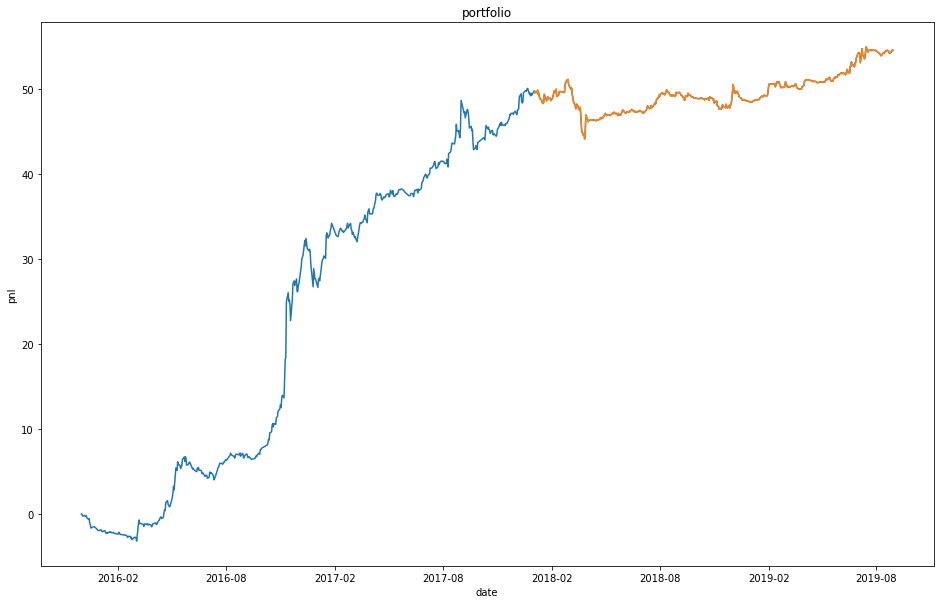

In [187]:
i = 0
all_pnl = np.zeros([n_days, len(product_list)])
min_pnl = 5
min_num = 5
for product in product_list:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    all_pnl[:len(train_pnl),i] = train_pnl
    all_pnl[len(train_pnl):n_days,i] = test_pnl
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
all_portfolio = np.array(np.mean(all_pnl, axis=1))
train_portfolio = all_portfolio[train_sample]
test_portfolio = all_portfolio[test_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# rb train sharpe  1.7802624234073527 test sharpe  1.3700872646291402
# hc train sharpe  1.0243214633351445 test sharpe  -0.16230882896170815
# i train sharpe  1.3671763541958544 test sharpe  0.6120676935188223
# j train sharpe  1.9806948239661617 test sharpe  0.1772491377059502
# jm train sharpe  1.5449205647259607 test sharpe  0.22933561313413867
# train sharpe:  2.530555311223734 test sharpe:  0.6473295056360518


- we can see that the test result accpetable even though there is a small drawback
